# Project 2: How do perturbations to initial turning angle and radial electron density affect orbital stability?

## Introduction

The purpose of this project is to explore the orbital stability as a function of minor angular interference on a singular electron in $n$-Body systems with a fixed nucleus. The orbital stability of the system is defined as the average absolute standard deviation of the orbital distance of all electrons in the system over an angular period (that being, in the time that it takes the electron to reach the same angle with respect to the nucleus, how much does the distance that electron travels deviate on average). More stable systems will minimize this average deviation, and the value can be defined loosely from there.

**Code Block Summary:** Imports

In [1]:
from numpy.testing import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from PIL import Image
import io

**Code Block Summary:** Constants

In [2]:
NUM_PERIODS=10

# orbital radius of all of the electrons
bohr_radius = 5.29e-11

# electron mass
m = 9.1e-31

# coulomb's constant
k = 9e9

# charge of an electron
q = 1.6e-19

**Code Block Summary:** This function saves graphs to memory to be stored into variables, and from there, I can called them again using `display`. This workflow makes managing the Jupyter notebook easy, and it also allows me to define all of my graphs together but display them in separate cells.

In [3]:
def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph

**Code Block Summary:** Vector Rotation

Counterclockwise rotation of a vector $\mathbf{v}$ by angle $\theta$ is just multiplication by the rotation matrix $\mathbf{R}(\theta)$

$$R(\mathbf{v},\theta) = \mathbf{R}(\theta) \mathbf{v} = \begin{pmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{pmatrix} \mathbf{v}.$$

In [4]:
def rotate_vector_2d(vec, theta):
    """
    Rotates vector `vec` counterclockwise by `theta` radians
    """
    rotation_matrix = \
        np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    rotation_matrix[np.abs(rotation_matrix) < 1e-15] = 0
    return rotation_matrix @ vec

In [5]:
def test_rotate_vector_2d():
    ihat = np.array([1,0])
    jhat = np.array([0,1])
    
    # Rotating (1,0) by 90 deg counter clockwise should give (0,1)
    assert_allclose(rotate_vector_2d(ihat,  np.pi/2), jhat, atol=1e-6)
    # And vice versa
    assert_allclose(rotate_vector_2d(jhat, -np.pi/2), ihat, atol=1e-6)
    
    # realistic velocity case
    v = 4e16
    vec0 = np.array([0,v])
    rotated = np.array([v,0])
    
    assert_allclose(rotate_vector_2d(vec0, -np.pi/2), rotated, rtol=1e-10)
    
    print('(Test) `rotate_vector_2d` successful')
    
test_rotate_vector_2d()

(Test) `rotate_vector_2d` successful


**Code Block Summary:** These are some functions for applying vector operations along lists of vectors, like getting the unit vector (or direction) of a vector and getting the unit vector of each vector in a list.

For `unit_vector`: unit vectors can always be calculated as
$$\hat{v} = \frac{\mathbf{v}}{|\mathbf{v}|}$$
(for simplicity, I may also write $|\mathbf{v}|$ as $v$).

In [6]:
def unit_vector(v):
    """
    Returns the associated unit
    """
    return np.array(v) / np.linalg.norm(v)

def magnitudes(vector_list):
    return np.array([np.linalg.norm(vec) for vec in vector_list])

def unit_vectors(s):
    return np.array([unit_vector(v) for v in s])

In [7]:
def test_unit_vector():
    v1 = np.array([1,0])
    assert_allclose(unit_vector(v1), v1)
    v2 = np.array([1,1])
    assert_allclose(unit_vector(v2), v2/np.sqrt(2))
    print('(Test) `unit_vector` successful')
    
test_unit_vector()

def test_magnitudes():
    vs = np.array([[1,0],[0,1],
                   [1/np.sqrt(2),1/np.sqrt(2)],
                   [4/np.sqrt(2),4/np.sqrt(2)]])
    test = magnitudes(vs)
    assert_allclose(test, np.array([1, 1, 1, 4]))
    print('(Test) `magnitudes` successful')
    
test_magnitudes()

(Test) `unit_vector` successful
(Test) `magnitudes` successful


**Code Block Summary:** This is a smoothing function to handle minute errors due to floating point calculations. For some dataset vector $x = (x_1, x_2, \dots, x_n)$, it smooths the data by first calculating the absolute tolerance $\beta$ as a function of some relative tolerance $\alpha$ as
$$\beta = (\max(x) - \min(x))\alpha$$
then it smooths out the data by setting each datapoint by setting all points where the deviation is less than the absolute tolerance as the mean of the data
$$x_i = \begin{cases} 
\overline{x} & \text{if } |x_i - \overline{x}| < \beta \\
x_i & \text{elsewhere}
\end{cases}.$$

In [8]:
def smooth(v, rtol=1e-6):
    """
    Smooths a data vector `v` by 
    relative tolerance `rtol`. 
    """
    
    tol = (np.max(v) - np.min(v)) * rtol
    v_smooth = np.copy(v)
    v_smooth[np.abs(v - np.mean(v)) < tol] = np.mean(v)
    
    return v_smooth

**Code Block Summary:** This is a function for converting a list of cartesian coordinates (i.e., a cartesian trajectory) into a list of polar coordinates (i.e., a polar trajectory). Cartesian trajectories are passed in with as a pair $$\langle \mathbf{x}(t), \mathbf{y}(t) \rangle = \langle (x_1, x_2, x_3, \dots, x_n), (y_1, y_2, y_3, \dots, y_n ) \rangle,$$ and from there, these coordinate lists can be easily converted into polar coordinates as $$r = \sqrt{x^2 + y^2}$$ and $$\theta = \tan^{-1}(y/x),$$ producing list $$\langle \mathbf{r}, \mathbf{\theta} \rangle = \langle (r_1, r_2, r_3, \dots, r_n), (\theta_1, \theta_2, \theta_3, \dots, \theta_n) \rangle.$$

In [9]:
def cartesian_to_polar(coords):
    """
    Convert an array of 2D Cartesian coordinates 
    to polar coordinates. Coordinates must be of 
    shape (2,n).
    """
    coords = np.asarray(coords)

    if coords.ndim == 2 and coords.shape[0] == 2:
        x = coords[0]
        y = coords[1]
        r = np.sqrt(x**2 + y**2)
        theta = np.unwrap(np.arctan2(y, x))
        
        return np.array([r, theta])

    else:
        raise ValueError(f"Expected shape (2,n), got {coords.shape}")

In [10]:
def test_cartesian_to_polar():
    test1 = cartesian_to_polar([
        [ 1,   np.sqrt(2)/2,   0,       -np.sqrt(2)/2,   -1,    -np.sqrt(2)/2,    np.sqrt(2)/2,   1       ],
        [ 0,   np.sqrt(2)/2,   1,        np.sqrt(2)/2,    0,    -np.sqrt(2)/2,   -np.sqrt(2)/2,   0       ]])
    answer1 = np.array([
        [ 1,   1,              1,        1,               1,     1,               1,              1       ], 
        [ 0,   np.pi/4,        np.pi/2,  3*np.pi/4,       np.pi, 5*np.pi/4,       7*np.pi/4,      2*np.pi ]])
    assert_allclose(test1, answer1)
    print('(Test) `cartesian_to_polar` successful')
    
test_cartesian_to_polar()

(Test) `cartesian_to_polar` successful


**Code Block Summary:** These blocks are code for simplifying the state system of `solve_ivp` for my Electron usecase. `ElectronState` defines the most basic state information for an individual electron in a state vector.

In [11]:
@dataclass
class ElectronState:
    pos: np.array = None
    vel: np.array = None

`interpret_state` unpacks a one-electron state vector from $[x, y, v_x, v_y]$ into separate vectors $\mathbf{r}=\langle x, y\rangle$ and $\mathbf{v}=\langle v_x, v_y \rangle$.

In [12]:
def interpret_state(state):
    """
    Unpacks a one-electron state vector
    into an ElectronState.
    """
    pos = np.array(state[0:2])
    vel = np.array(state[2:4])
        
    return ElectronState(pos, vel)

In [13]:
def test_interpret_state():
    example_state = [ 1, 2, 3, 4 ]
    interpretation = interpret_state(example_state)
    assert_allclose(interpretation.pos, np.array([1, 2]))
    assert_allclose(interpretation.vel, np.array([3, 4]))
    print('(Test) `interpret_state` successful')
    
test_interpret_state()

(Test) `interpret_state` successful


`set_state_index` essentially does the opposite and packs a state vector with position and velocity components into a multi-electron state vector.

In [14]:
def set_state_index(state, i, pos, vel):
    base = 4 * i
    state[base : base + 4] = [pos[0], pos[1], vel[0], vel[1]]

In [15]:
def test_set_state_index():
    example_state = np.zeros(12)
    set_state_index(example_state, 1, np.array([1, 2]), np.array([3, 4]))
    assert_allclose(example_state, np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0]))
    print('(Test) `set_state_index` successful')

test_set_state_index()

(Test) `set_state_index` successful


`get_state` is a selector for a multi-electron state vector to get a singular electron state.

In [16]:
def get_state(state, i):
    """
    Slices an n-electron state 
    vector on electron index i
    """
    return state[4*i : 4*i + 4]

In [17]:
def test_get_state():
    example_state = np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0])
    test = get_state(example_state, 1)
    assert_allclose(test, np.array([1, 2, 3, 4]))
    print('(Test) `get_state` successful')
    
test_get_state()

(Test) `get_state` successful


`get_electron` is a composition of `get_state` and `interpret_state` to automatically select and unpack the electron state at electron index $i$ in a multi-electron state vector.

In [18]:
def get_electron(state, i):
    return interpret_state(get_state(state, i))

In [19]:
def test_get_electron():
    example_state = np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0])
    test = get_electron(example_state, 1)
    assert_allclose(test.pos, np.array([1, 2]))
    assert_allclose(test.vel, np.array([3, 4]))
    print('(Test) `get_electron` successful')
    
test_get_electron()

(Test) `get_electron` successful


**Code Block Summary:** This is the function for calculating the coulomb force between two objects, A and B. The distance vector should be $\mathbf{d} = \mathbf{r}_A - \mathbf{r}_B,$ i.e., the displacement vector between the two of them. The calculation then made is
$$\mathbf{F} = \frac{kq^2}{|\mathbf{d}|^3} \mathbf{d}$$
if this is a force between two electrons only and
$$\mathbf{F} = -N\frac{kq^2}{|\mathbf{d}|^3} \mathbf{d}$$
if this is between an electron and the nucleus, where $N$ is the number of protons in the nucleus.

In [20]:
def calculate_coulomb_force(distance_vec, attract=False, num_protons=1):
    mag = k * q ** 2 / np.linalg.norm(distance_vec) ** 3 * distance_vec
        
    # reverse direction if it's attractive
    if attract:
        return num_protons * mag * -1
    else:
        return mag

**Code Block Summary:** This is a more involved test to ensure that the coulomb force calculation is completely correct. The first test is the trivial ($N=1$) electron-proton case. The second test is an electron-electron calculation from $(r_0,0)$ to $(0,r_0)$. For an electron at $(r_0,0)$ and $(0,r_0)$ (or $(r_0,0)$ and $(r_0, \pi/2)$), $\mathbf{r} = \langle r_0, -r_0 \rangle$, making $\hat{r} = 1/\sqrt{2}(i - j)$
$$\mathbf{F} = \frac{kq^2}{r^2} \hat{r} = \frac{kq^2}{2r_0^2} \frac{r_0}{\sqrt{2}}(\hat{i} - \hat{j}) = \frac{kq^2}{2^{3/2} r_0^2} (\hat{i} - \hat{j})$$

In [21]:
def test_calculate_coulomb_force():
    # electron-proton
    electron_pos = np.array([bohr_radius, 0])
    proton_pos   = np.array([0,  0])
    
    distance_vec  = electron_pos - proton_pos
    answer        = np.array([-k * q ** 2 / bohr_radius ** 2, 0])
    force_attract = calculate_coulomb_force(distance_vec, attract=True)
    assert_allclose(force_attract, answer)
    
    # electron-electron
    other_electron_pos = np.array([0, bohr_radius])
    distance_vec_2     = electron_pos - other_electron_pos
    answer_2           = (k * q ** 2) / (2 ** (3/2) * bohr_radius ** 2) * np.array([ 1, -1 ])
    force_attract_2    =  calculate_coulomb_force(distance_vec_2, attract=False)
    assert_allclose(force_attract_2, answer_2)
    
    print('(Test) `calculate_coulomb_force` successful')
    
test_calculate_coulomb_force()

(Test) `calculate_coulomb_force` successful


**Code Block Summary:** This block calculates the necessary starting values (radial distance, initial tangential velocity, and the period). The idea for this simulation is that the simulation begins at its most stable uniform-orbit configuration for each $N$, and these calculations are made with that in mind, so these values don't depend on the initial incidence angle.

*Derivation:* Knowing that the number of electrons $N$ is equal to the number of protons $Z$. The radial distance is $r = \frac{N^2}{Z^2} a_0 = a_0$, the nuclear attraction is
$$\mathbf{F}_{nuc} = -Z \frac{kq^2}{r^2}.$$
Using the incidence electron $\theta=0$ as our basepoint (which is okay as all of the electrons will have the same tangential velocity in the end), the coordinates of the incidence electron would be $(r,0)$ (both cartesian and polar) and $(r\cos\theta_j,r\sin\theta_j)$ for the other electron in cartesian coordinates. 

As $\theta = \frac{2\pi}{N}j$, this makes the displacement vector between them (pointing toward the incidence electron)
$$\mathbf{d}_j=(r,0)-\left(r\cos\theta_j,r\sin\theta_j\right)=r \left\langle 1-\cos\theta_j, -\sin\theta_j \right\rangle.$$
Then, easily, we can calculate the coulombic force as
$$\mathbf{F}_j = \frac{kq^2}{|\mathbf{d}_j|^3} \mathbf{d}_j,$$
and the total repulsive force would therefore be 
$$\mathbf{F}_{rep} = \sum_{j=1}^{N-1} \mathbf{F}_j,$$
which makes the net force
$$\mathbf{F}_{net} = \mathbf{F}_{nuc} + \mathbf{F}_{rep}$$
Then, acceleration is $a=F/m$ and the speed is $v=\sqrt{ar}$. The velocity must be tangential to the circle, so $\theta_v=\theta_j+\pi/2$ and $T=\frac{2\pi r}{v}$.

In [22]:
def calculate_starting_values(num_electrons):
    """
    Calculates the necessary tangential velocity 
    and radial distance to have the most stable 
    uniform circular orbit for a given starting
    number of electrons N.
    
    Estimates the period as well based off of
    this, without consideration of the incidence
    angle theta.
    """
    radius = bohr_radius
    f_nuc  = np.array([-num_electrons * k * q ** 2 / radius ** 2, 0])
    theta  = np.linspace(0, 2 * np.pi, num_electrons, endpoint=False)[1:]
    
    f_rep = np.zeros(2)
    if num_electrons > 1:
        dist   = radius * np.array([ 1 - np.cos(theta), -np.sin(theta) ])
        forces = k * q ** 2 * dist / np.linalg.norm(dist,axis=0)
        f_rep  = np.sum(forces, axis=1)
    
    f_net = f_nuc + f_rep    
    accel = f_net / m
    
    speed  = np.sqrt(np.linalg.norm(accel) * radius)
    period = 2 * np.pi * radius / speed
    
    return radius, speed, period

In [23]:
def test_calculate_starting_values():
    # Trivial Case, N=0
    f_trivial = k * q ** 2 / bohr_radius ** 2
    a_trivial = f_trivial / m
    v_trivial = np.sqrt(a_trivial * bohr_radius)
    T_trivial = 2 * np.pi * bohr_radius / v_trivial
    
    trivial = calculate_starting_values(1)
    assert_allclose(trivial, (bohr_radius, v_trivial, T_trivial), atol=1e-6)
    
    # n=5 case
    radius_5, v_5, T_5 = calculate_starting_values(5)
    
    # Check radius unchanged
    assert_allclose(radius_5, bohr_radius, atol=1e-12)
    
    # Check that period matches 2*pi*r/v
    assert_allclose(T_5, 2*np.pi*radius_5 / v_5, atol=1e-12)
    
    # Optional: check that speed is positive
    assert v_5 > 0
    
    print('(Test) `calculate_starting_values` successful')
    
test_calculate_starting_values()

(Test) `calculate_starting_values` successful


**Code Block Summary:** This function generates the initial state given the number of electrons $N$ and the incidence angle $\theta$. Essentially, what it does is it produces the initial state vector for each electron, equally angularly spaced along the circular orbit curve of the nucleus.  

In [24]:
def generate_initial_state(num_electrons, incidence_angle=None):
    """
    Produces the initial state to match the number 
    of electrons and the incidence angle
    """
    angles = np.linspace(0, 2 * np.pi, num_electrons, endpoint=False)
    radius, velocity, period = calculate_starting_values(num_electrons)
    
    if num_electrons <= 0:
        raise ValueError('num_electrons must be a natural number')
    
    state = np.zeros(4 * num_electrons)
    for i, theta in enumerate(angles):
        pos = radius * np.array([ np.cos(theta), np.sin(theta)])
        vel = velocity * np.array([-np.sin(theta), np.cos(theta)])
        set_state_index(state, i, pos, vel)
    
    # apply an incidence angle to the interest electron 
    # (always at theta=0) if the user supplied one
    if incidence_angle is not None:
        vel = np.array(state[2:4])
        rotated = rotate_vector_2d(vel, incidence_angle)
        state[2] = rotated[0]
        state[3] = rotated[1]
        
    return state, period

In [25]:
def test_generate_initial_state():
    r0, v0, _ = calculate_starting_values(1)
    
    trivial, _ = generate_initial_state(1)
    assert_allclose(trivial, np.array([r0, 0, 0, v0]))
    
    incidence_angle, _ = generate_initial_state(1, -np.pi/2)
    assert_allclose(incidence_angle, np.array([r0, 0, v0, 0]), atol=1e-6)
    
    # n=4 test
    r, v, _ = calculate_starting_values(4)
    
    higher_n, _ = generate_initial_state(4, 0)
    assert_allclose(higher_n, np.array([
         r,  0,  0,  v,
         0,  r, -v,  0,
        -r,  0,  0, -v,
         0, -r,  v,  0
    ]), atol=1e-6)
    print('(Test) `generate_initial_state` successful')
    
test_generate_initial_state()

(Test) `generate_initial_state` successful


**Code Block Summary:** This function calculates the orbital stability score of an orbit path as measured by the variance in $|\langle \frac{d^2r}{dt^2}, \frac{d^2 \theta}{dt^2} \rangle|$ normalized by the average.

In [26]:
def calculate_orbital_stability(time, polar_trajectory):
    radial  = polar_trajectory[0]
    angular = polar_trajectory[1]
    
    second_deriv = lambda x: np.diff(x, n=2)/(np.diff(time, n=2) + 1e-20)
    normalize = lambda x: x / (np.mean(x) + 1e-20)
    
    dr = normalize(second_deriv(radial))
    dtheta = normalize(second_deriv(angular))
    
    gradients = np.array([dr, dtheta])
    gradients = np.linalg.norm(gradients, axis=0)
    
    return np.var(gradients)

In [27]:
def test_calculate_orbital_stability():
    # trivial case: roughly constant movement
    trivial_polar_trajectory = np.array([[5.29e-11, 5.29e-11, 5.29e-11, 5.29e-11, 5.29e-11, 5.289999999999999e-11, 5.2899999999973413e-11, 5.2899999999719824e-11, 5.289999999904584e-11, 5.2899999997796087e-11, 5.28999999958277e-11, 5.289999999300002e-11, 5.289999998917059e-11, 5.289999998419584e-11, 5.289999997793806e-11, 5.289999997028217e-11, 5.289999996116759e-11, 5.289999995063784e-11, 5.289999993889987e-11, 5.2899999926362346e-11, 5.289999991360713e-11, 5.289999990127884e-11, 5.289999988994644e-11, 5.28999998800157e-11, 5.289999987171765e-11, 5.289999986514268e-11, 5.2899999860282325e-11, 5.2899999857059946e-11, 5.289999985534643e-11, 5.289999985496092e-11, 5.2899999855915115e-11, 5.289999985719548e-11, 5.28999998588157e-11, 5.289999986069596e-11, 5.2899999862753236e-11, 5.289999986491182e-11, 5.289999986708935e-11, 5.289999986919218e-11, 5.2899999871116155e-11, 5.289999987275406e-11, 5.289999987401327e-11, 5.289999987484802e-11, 5.2899999875306316e-11, 5.2899999875577385e-11, 5.289999987600475e-11, 5.289999987703012e-11, 5.289999987908029e-11, 5.289999988246331e-11, 5.289999988732759e-11, 5.2899999893678385e-11, 5.289999990141505e-11, 5.289999991036183e-11, 5.28999999202814e-11, 5.28999999308672e-11, 5.28999999408741e-11, 5.2899999949976136e-11, 5.289999995889427e-11, 5.289999996971825e-11, 5.2899999981745804e-11, 5.2899999994580144e-11, 5.290000000792483e-11, 5.290000002151796e-11, 5.290000003510601e-11, 5.290000004843437e-11, 5.290000006125017e-11, 5.290000007331913e-11, 5.290000008446012e-11, 5.290000009459588e-11, 5.290000010380191e-11, 5.2900000112316153e-11, 5.290000012047937e-11, 5.290000012862942e-11, 5.2900000137014274e-11, 5.2900000145763357e-11, 5.2900000154903896e-11, 5.290000016439001e-11, 5.2900000174124536e-11, 5.290000018396657e-11, 5.2900000193720865e-11, 5.290000020223265e-11, 5.2900000210668355e-11, 5.2900000218743033e-11, 5.290000022757767e-11, 5.290000023660492e-11, 5.2900000245424125e-11, 5.2900000253700546e-11, 5.290000026112707e-11, 5.290000026740949e-11, 5.2900000272265865e-11, 5.2900000275439964e-11, 5.2900000276732744e-11, 5.2900000276054094e-11, 5.290000027348515e-11, 5.290000026931802e-11, 5.2900000264027805e-11, 5.290000025816704e-11, 5.290000025223911e-11, 5.2900000246621935e-11, 5.2900000241558723e-11, 5.290000023718632e-11, 5.290000023356913e-11, 5.290000023072451e-11, 5.2900000228637335e-11, 5.290000022795886e-11, 5.290000022793263e-11], [0.0, 4.5709565840908357e-07, 5.028052242499919e-06, 5.073761808340828e-05, 0.0005078332764924918, 0.005078789860583328, 0.033078592317969564, 0.07383649980839826, 0.12173945595832007, 0.17473115212782908, 0.23176074318336662, 0.29219194595131487, 0.35559780065603397, 0.4216663371588204, 0.4901452819485468, 0.5608001585897692, 0.6333746032741164, 0.7075495111998448, 0.7829067109069743, 0.8589140640252676, 0.9349522775381844, 1.0103840754389675, 1.0846323290670932, 1.1572245064723738, 1.2277889940964994, 1.2960182890262963, 1.36161836883082, 1.4242508579574853, 1.4834570072831368, 1.5385219190862651, 1.5791425257819725, 1.619732383816372, 1.6638470532062797, 1.7140370666466795, 1.7688055894112389, 1.8273127256250836, 1.8890251961202509, 1.9535722354996883, 2.020672295730845, 2.0900853077098125, 2.1615725834820045, 2.2348566120687967, 2.3095807555089434, 2.3852792253461823, 2.461377571714341, 2.537239032584537, 2.6122430141025093, 2.68585335630041, 2.7576423701451795, 2.827270715521759, 2.8944430326288844, 2.9588544463625595, 3.0201276861416053, 3.077720261693007, 3.1242994954417016, 3.164120223936089, 3.20189186253784, 3.247880502589437, 3.299436956926098, 3.355297251303575, 3.4147276090967553, 3.477249322747796, 3.5425218177279922, 3.6102791292528957, 3.6802854795265016, 3.7522956141017825, 3.8260141929844362, 3.9010567678787496, 3.9769258941342374, 4.053023497178312, 4.128708994584555, 4.203379660398109, 4.276528822321785, 4.347756436769687, 4.416740184129794, 4.48318766970435, 4.546781103612565, 4.607109388729472, 4.663558787950962, 4.707694592960023, 4.751801790970031, 4.7940585174974295, 4.842944987764339, 4.896692712733651, 4.954347075787226, 5.0153178826505656, 5.079203147975567, 5.145704563544826, 5.214575759988981, 5.285581348351101, 5.3584570634719055, 5.432868978012786, 5.508379380690835, 5.584437820520707, 5.660416122610269, 5.7356822913514005, 5.80967544451556, 5.881941933578346, 5.952124417933594, 6.019921529821969, 6.0850359816558255, 6.147114937098614, 6.2056679995120785, 6.254094608791819, 6.283185304281992]])
    trivial_time = np.array([0.0, 1.105274277769807e-23, 1.2158017055467877e-22, 1.2268544483244859e-21, 1.2279597226022557e-20, 1.2280702500300326e-19, 7.998526470614325e-19, 1.785393986953936e-18, 2.9437052569627915e-18, 4.2250641504700545e-18, 5.604060841839397e-18, 7.065309767573334e-18, 8.598486881662407e-18, 1.0196048630208628e-17, 1.1851894945924015e-17, 1.3560356101406e-17, 1.5315233124435598e-17, 1.7108809942271246e-17, 1.8930975013597186e-17, 2.076886103491787e-17, 2.260749327108052e-17, 2.443146215162082e-17, 2.6226812491309246e-17, 2.7982118292263276e-17, 2.968839380081837e-17, 3.133820348252506e-17, 3.292443776599791e-17, 3.443891460489402e-17, 3.58705412752304e-17, 3.7202031284803265e-17, 3.818425263459774e-17, 3.9165730470387024e-17, 4.0232439553357107e-17, 4.1446052710961845e-17, 4.277037592385937e-17, 4.418510019801054e-17, 4.567733064517087e-17, 4.723810202040068e-17, 4.886060638774642e-17, 5.0539038787137875e-17, 5.226762765519746e-17, 5.403966267340371e-17, 5.584652020341403e-17, 5.767693730739744e-17, 5.9517023574307e-17, 6.13513818618972e-17, 6.316500598042233e-17, 6.494493138288559e-17, 6.668081638977837e-17, 6.836445563122802e-17, 6.998870719766333e-17, 7.15461990959372e-17, 7.302780878335633e-17, 7.442041864369993e-17, 7.554672181052794e-17, 7.650960181122802e-17, 7.742293405779288e-17, 7.853495645092897e-17, 7.978161066148385e-17, 8.11323333230284e-17, 8.256938144440605e-17, 8.40811796991949e-17, 8.565949286888694e-17, 8.729788982627133e-17, 8.899066937670115e-17, 9.073190117655944e-17, 9.251444379506501e-17, 9.432900112958564e-17, 9.616354478364189e-17, 9.800361309185409e-17, 9.983371653315581e-17, 1.0163928097004196e-16, 1.0340805487814655e-16, 1.0513036505496056e-16, 1.0679841769253493e-16, 1.0840514257845538e-16, 1.099428554353336e-16, 1.1140161578193453e-16, 1.12766583227021e-16, 1.1383380338968465e-16, 1.1490033182482267e-16, 1.1592211517231686e-16, 1.1710420818702917e-16, 1.1840384814707687e-16, 1.1979795206801002e-16, 1.2127224883301202e-16, 1.2281701828700386e-16, 1.2442504722641827e-16, 1.2609037834830143e-16, 1.2780731986012132e-16, 1.295694817320141e-16, 1.3136878947671067e-16, 1.331946590725921e-16, 1.350337804101494e-16, 1.368709639869574e-16, 1.3869092791430807e-16, 1.4048010985149114e-16, 1.4222754040865425e-16, 1.4392457895722463e-16, 1.4556393831288031e-16, 1.4713842995137345e-16, 1.486395221590688e-16, 1.500553569631224e-16, 1.5122633036791133e-16, 1.5192975419319306e-16])
    trivial_stability = calculate_orbital_stability(trivial_time, trivial_polar_trajectory)
    
    # this value should be reasonably low
    print('Trivial Case Stability:', trivial_stability)
    
test_calculate_orbital_stability()

Trivial Case Stability: 313.24784157233404


**Code Block Summary:** This is the function to calculate the trajectory of all of the electrons in the system by solving the differential equations.

In [28]:
@dataclass
class ElectronData:
    pos:            np.array = None
    radial_pos:     np.array = None
    vel:            np.array = None
    
    kinetic_energy:   np.array = None
    potential_energy: np.array = None
    momentum:         np.array = None

@dataclass
class CalculationResult:
    time:            np.array   = None
    electrons:       list       = None
    stability_score: np.float64 = -1
    
    total_kinetic_energy:    np.array = None
    total_potential_energy:  np.array = None
    total_mechanical_energy: np.array = None
    total_momentum:          np.array = None

def calculate(n, angle, num_periods=NUM_PERIODS, rtol=1e-9, atol=1e-9):
    state0, period = generate_initial_state(n, angle)
    t_span = (0, num_periods * period)

    def diff_eqns(t, state):
        # state is a flat 1D array of length 4*n
        state_delta = np.zeros_like(state)

        for i in range(n):
            electron = get_electron(state, i)

            # attractive net force contribution from the nucleus
            net_force = calculate_coulomb_force(electron.pos, attract=True, num_protons=n)

            # repulsive net force contribution from the other electrons
            for j in range(n):
                if i == j:
                    continue

                other = get_electron(state, j)
                net_force += calculate_coulomb_force(electron.pos - other.pos)

            accel = net_force / m
            set_state_index(state_delta, i, electron.vel, accel)

        return state_delta


    calculation = solve_ivp(diff_eqns, t_span, state0, rtol=rtol, atol=atol)
    
    results = CalculationResult()
    results.time = np.array(calculation.t)
    results.electrons = []
    
    for i in range(n):
        electron = get_electron(calculation.y, i)
        pos = electron.pos
        vel = electron.vel
        radial_pos = cartesian_to_polar(pos)
        
        kinetic_energy = (1/2) * m * magnitudes(vel.transpose()) ** 2
        momentum       = m * magnitudes(vel)
        
        potential_energy = np.zeros_like(results.time)

        for t_idx in range(len(results.time)):
            r_i = pos[:, t_idx]
            U_nuc = -n * k * q**2 / np.linalg.norm(r_i)

            U_rep = 0
            for j in range(n):
                if i == j:
                    continue
                other = get_electron(calculation.y, j)
                r_j = other.pos[:, t_idx]
                U_rep += k * q**2 / np.linalg.norm(r_i - r_j)

            # 1/2 to avoid double-counting
            potential_energy[t_idx] = U_nuc + 0.5 * U_rep

        results.electrons.append(ElectronData(pos, radial_pos, vel, \
                                              kinetic_energy, potential_energy, momentum))
    
    results.stability_score      = np.mean([calculate_orbital_stability(results.time, electron.radial_pos) \
                                            for electron in results.electrons])
    results.total_kinetic_energy = np.sum([electron.kinetic_energy \
                                           for electron in results.electrons], axis=0)
    results.total_potential_energy  = np.sum([electron.potential_energy \
                                              for electron in results.electrons], axis=0)
    results.total_mechanical_energy = results.total_kinetic_energy + results.total_potential_energy
    
    results.total_momentum = np.sum([electron.momentum for electron in results.electrons], axis=0)
    
    return results

**Code Block Summary:** This code tests the barebones calculations performed under `calculate` for the trivial case $n=1$. This makes for a good test, as we know that this should be an automatically stable orbit with the simplest conditions under the Bohr model.

In [29]:
def test_calculation_raw():
    trivial_state, period = generate_initial_state(1, 0)
    
    def diff_eqns(t, state):
        state_delta = np.zeros_like(state)
        electron = get_electron(state, 0)
        net_force = calculate_coulomb_force(electron.pos, attract=True)
        
        accel = net_force / m
        set_state_index(state_delta, 0, electron.vel, accel)

        return state_delta
    
    calculation = solve_ivp(diff_eqns, (0, period), trivial_state, rtol=1e-9, atol=1e-9)
    electron = get_electron(calculation.y, 0)
    radial_pos = cartesian_to_polar(electron.pos)
    results = dict()
    
    # Cartesian trajectory
    plt.figure()
    plt.plot(electron.pos[0], electron.pos[1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.grid(True)
    results['cartes'] = save_graph_and_close()
    
    # Polar trajectory
    plt.figure()
    plt.plot(radial_pos[1], radial_pos[0])
    plt.xlabel('θ (rad)')
    plt.ylabel('Radial Distance from Nucleus (m)')
    plt.title(f'Radial Trajectory of 10 orbits for the Affected Electron')
    plt.grid(True)
    results['polar'] = save_graph_and_close()
    
    # Speed vs. Time graph
    plt.figure()
    speed = magnitudes(electron.vel.transpose())
    plt.plot(calculation.t, speed)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs. Time')
    plt.grid(True)
    results['speed'] = save_graph_and_close()
    
    return results
    
trivial_test = test_calculation_raw()

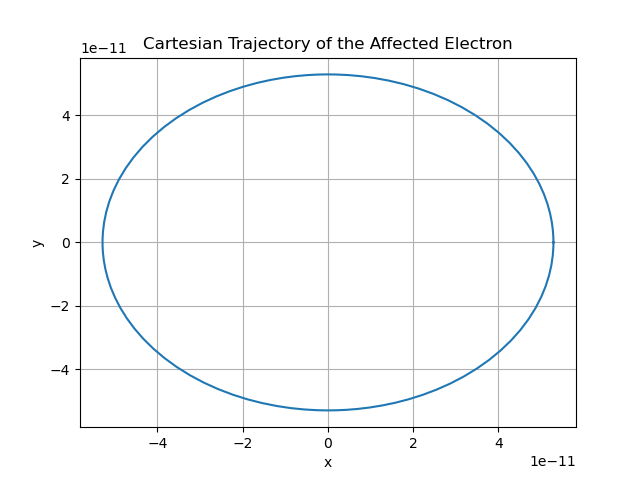

In [30]:
display(trivial_test['cartes'])

**Figure 1.** Visual observation confirms that the basic differential equations being used are conceptually correct and numerically stable for the trivial case, and this is best confirmed by simply understanding that the cartesian trajectory should be a perfectly uniform circle.

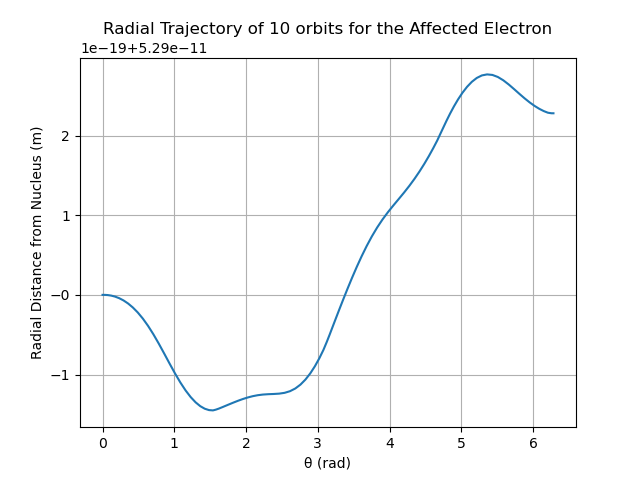

In [31]:
display(trivial_test['polar'])

**Figure 2.** The radial trajectory also confirms our claim. The variance of the graph can best be explained by floating point precision errors, as the variance of the graph is actually extremely small in comparison to $a_0$ (about $-2$ to $3\times 10^{-19}$ against $5.3 \times 10^{-11}$), so all of these values can be said to be roughly $a_0$ (hence the need for a smoothing function).

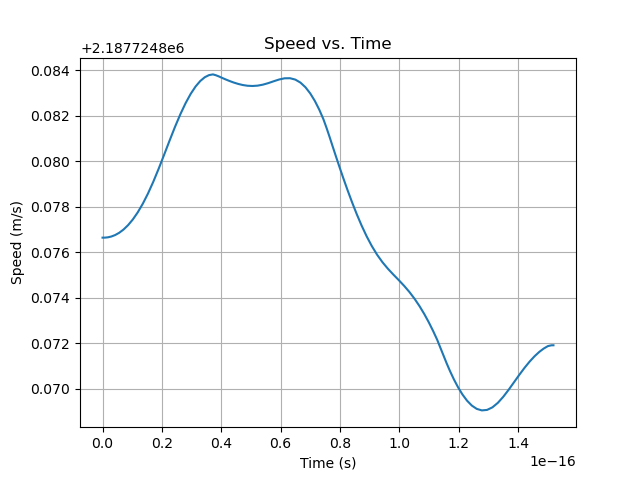

In [32]:
display(trivial_test['speed'])

**Figure 3.** Furthermore, the speed vs. time graph further confirms our suspicions. We see a variation in the graph here as well due to floating-point errors, even in the trivial case, as this velocity should be constant. Otherwise, however, as each of these values are roughly near each other, we can further state that the differential equations used are correct up to the point of floating point error.

**Code Block Summary:** This block visualizes a singular simulation, so it not only performs the necessary calculations but also provides some considerably more detailed plots, and this can aid in testing the full functionality of the `calculate` function for much higher $n$.

In [33]:
@dataclass
class Visualizations:
    radial_trajectory:    Image = None
    cartesian_trajectory: Image = None
    energy:               Image = None
    calc:                 CalculationResult = None
    
def simulate(n, angle, plot=False):
    sim = calculate(n, angle)
    affected_electron = sim.electrons[0]
    
    figures = Visualizations()
    
    # Radial distance vs. Angle
    plt.figure()
    plt.plot(affected_electron.radial_pos[1], smooth(affected_electron.radial_pos[0]))
    plt.xlabel('θ (rad)')
    plt.ylabel('Radial Distance from Nucleus (m)')
    plt.title(f'Radial Trajectory of the Affected Electron')
    plt.grid(True)
    figures.radial_trajectory = save_graph_and_close()
    
    # determine the scales
    plt.figure()
    
    # We want to show the full trajectory of this electron, 
    # but we want the x and y scales to match (in order to 
    # avoid producing a distortion/warping).
    x_min, x_max = np.min(affected_electron.pos[0]), np.max(affected_electron.pos[0])
    y_min, y_max = np.min(affected_electron.pos[1]), np.max(affected_electron.pos[1])
    x_span = x_max - x_min
    y_span = y_max - y_min
    span = max(x_span, y_span)
    
    x_mid = 0.5 * (x_min + x_max)
    y_mid = 0.5 * (y_min + y_max)

    plt.xlim(x_mid - span/2, x_mid + span/2)
    plt.ylim(y_mid - span/2, y_mid + span/2)
    
    # Cartesian Trajectory
    plt.plot(affected_electron.pos[0], affected_electron.pos[1], label='Trajectory')
    plt.plot(0, 0, 'ro', label='Nucleus')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.legend()
    plt.grid(True)
    figures.cartesian_trajectory = save_graph_and_close()

    # Speed vs. Time
    plt.figure()
    speed = magnitudes(affected_electron.vel.transpose())
    plt.plot(sim.time, smooth(speed))
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs. Time')
    plt.grid(True)
    figures.speed_graph = save_graph_and_close()
    
    # Energy Plot
    plt.figure()
    plt.plot(sim.time, affected_electron.kinetic_energy, label="Kinetic Energy")
    plt.plot(sim.time, sim.total_kinetic_energy,         label='Total Kinetic Energy')
    plt.plot(sim.time, sim.total_potential_energy,       label='Total Potential Energy')
    plt.plot(sim.time, sim.total_mechanical_energy,      label='Total Mechanical Energy')
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (J)")
    plt.title("Energy vs Time")
    plt.legend()
    plt.grid(True)
    figures.energy = save_graph_and_close()
    
    figures.calc = sim
    
    return figures

**Code Block Summary:** Now, we can perform a visual test of $n=5$ with an incidence angle of $\theta=-10^{-14}$ rad. It's a very small incidence angle, so this should be a roughly stable orbit, for some period of time before eventually breaking orbit.

In [34]:
test = simulate(n=5, angle=-1e-14)

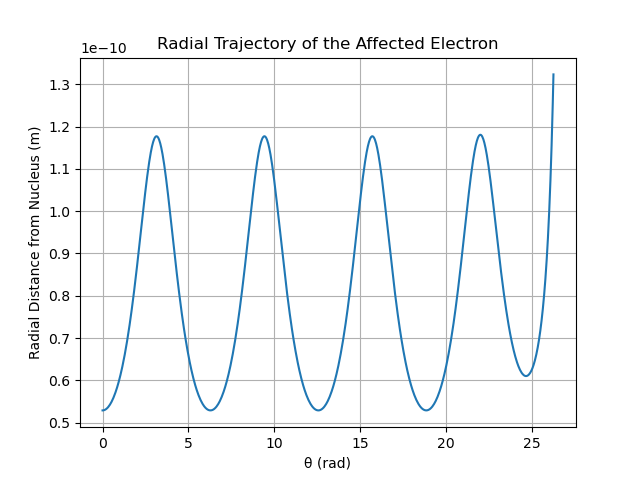

In [35]:
display(test.radial_trajectory)

**Figure 4.** As expected, the electron maintains a stable orbit for about three periods before diverting off path, so the system was certainly destabilized by having a higher $n$ and $\theta$, but having $\theta$ be so low still kept the orbit stable for quite a while before a complete destabilization.

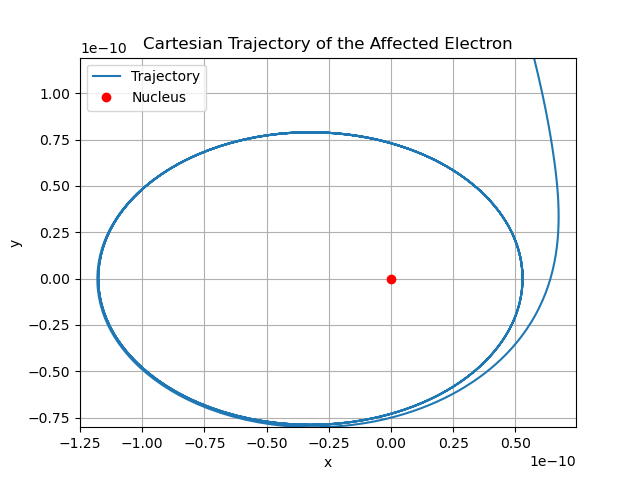

In [36]:
display(test.cartesian_trajectory)

**Figure 5.** The previous conclusion can be observed visually here. For one, the incidence angle produced a non-uniform orbit, being greatly ovular without the nucleus as the center. We can be certain that the orbit path is still stable for some time, but after a certain point, the incidence electron diverges from the stable path and flies outward.

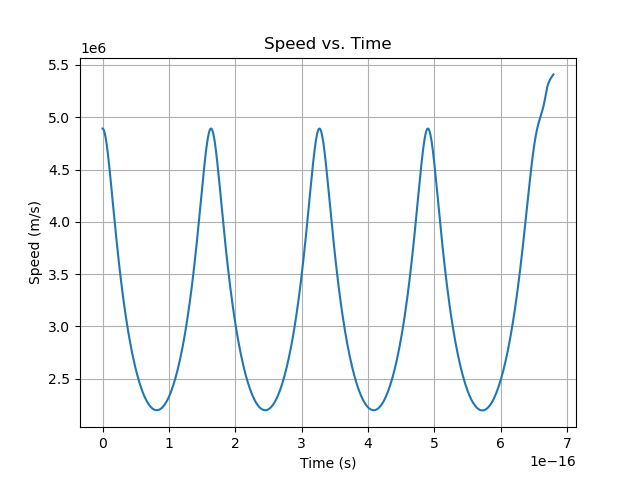

In [37]:
display(test.speed_graph)

**Figure 6.** Once more, we further see the previous behavior in the speed graph, as the speed graph is seemingly perfectly sinusoidal for roughly the first three periods then deviates from this path on the fourth. 

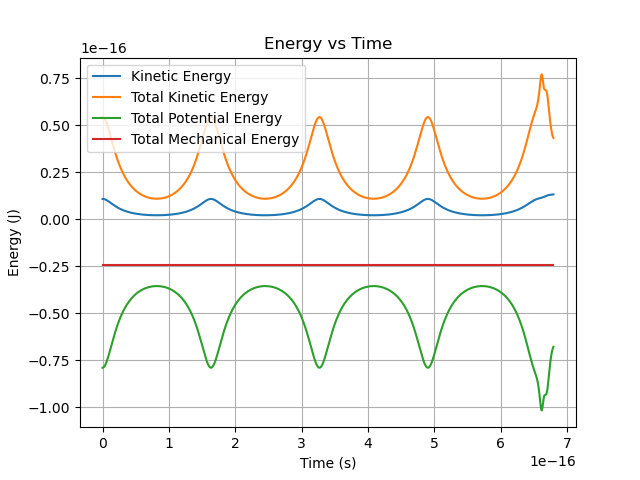

In [38]:
display(test.energy)

**Figure 8.** We can further verify the correctness of this simulation as the total mechanical energy stays constant, however interestingly, there seems to be an explosion (and periodic trend) of total kinetic and potential energy beginning from about $2 \times 10^{-16}$ seconds, and this is likely due to the imbalance in repulsion and attraction energy in the system as the overall system of orbits of all of the electrons begins to destabilize (that being, the distance between each of the electrons begins to change).

In [41]:
def generate_contour(n_domain, theta_domain, debug_print=False):            
    A, S = np.meshgrid(n_domain, theta_domain, indexing='ij')
    Z = np.zeros_like(A, dtype=float)
    total_sims = len(n_domain) * len(theta_domain)
    idx = 0
    interval = total_sims // 10
    if interval == 0:
        interval = 1
    for i, n in enumerate(n_domain):
        for j, theta in enumerate(theta_domain):
            idx += 1
            if debug_print and idx % interval == 0:
                print(f'{(idx / total_sims) * 100:.0f}% - Iteration {idx}/{total_sims}')
            Z[i,j] = calculate(n, theta).stability_score
    
    plt.figure()
    cp = plt.contourf(A, S, Z, levels=20, cmap='viridis')
    plt.colorbar(cp, label='Stability')
    plt.xlabel('Number of Electrons')
    plt.ylabel('Perturbation Angle (rad)')
    plt.title('Stability Score')
    plt.show()

10% - Iteration 10/100
20% - Iteration 20/100
30% - Iteration 30/100
40% - Iteration 40/100
50% - Iteration 50/100
60% - Iteration 60/100
70% - Iteration 70/100
80% - Iteration 80/100
90% - Iteration 90/100
100% - Iteration 100/100


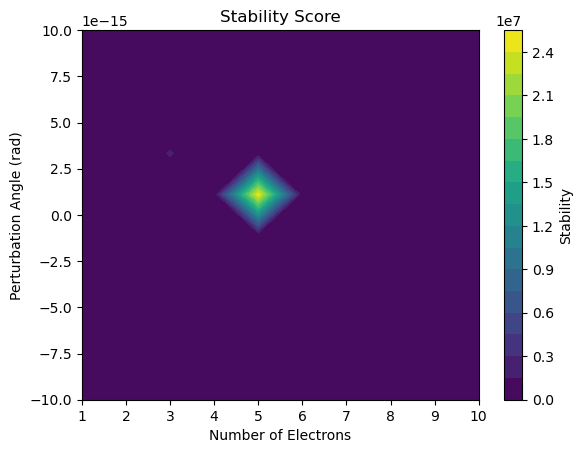

In [44]:
generate_contour(n_domain     = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                 theta_domain = np.linspace(-1e-14, 1e-14, 10),
                 debug_print  = True)